In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import joblib

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/EvaluationFile/train_data_evaluation_part_2.csv')
test_data = pd.read_csv('/content/drive/MyDrive/EvaluationFile/test_data_evaluation_part2.csv')

In [4]:
train_data.head()

,Unnamed: 0,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,0,1,PRT,51.0,150,45,371.0,105.3,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,PRT,NaN,1095,61,280.0,53.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,3,DEU,31.0,1095,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,FRA,60.0,1095,93,240.0,60.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5,FRA,51.0,1095,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_data.tail()

,Unnamed: 0,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
82575,82575,82576,SWE,51.0,12,114,190.08,6.0,0,0,...,0,0,0,0,1,0,0,0,0,0
82576,82576,82577,SWE,50.0,12,0,0.00,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
82577,82577,82578,DEU,50.0,12,18,222.00,255.0,0,0,...,0,0,0,0,0,0,0,0,0,0
82578,82578,82579,PRT,NaN,12,11,255.00,9.0,0,0,...,0,0,0,0,0,0,0,0,0,0
82579,82579,82580,DEU,17.0,12,0,0.00,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_data.shape

(82580, 30)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82580 entries, 0 to 82579
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            82580 non-null  int64  
 1   ID                    82580 non-null  int64  
 2   Nationality           82580 non-null  object 
 3   Age                   78834 non-null  float64
 4   DaysSinceCreation     82580 non-null  int64  
 5   AverageLeadTime       82580 non-null  int64  
 6   LodgingRevenue        82580 non-null  float64
 7   OtherRevenue          82580 non-null  float64
 8   BookingsCanceled      82580 non-null  int64  
 9   BookingsNoShowed      82580 non-null  int64  
 10  BookingsCheckedIn     82580 non-null  int64  
 11  PersonsNights         82580 non-null  int64  
 12  RoomNights            82580 non-null  int64  
 13  DaysSinceLastStay     82580 non-null  int64  
 14  DaysSinceFirstStay    82580 non-null  int64  
 15  DistributionChannel

In [8]:
train_data.describe()

,Unnamed: 0,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
count,82580.000000,82580.000000,78834.000000,82580.000000,82580.000000,82580.000000,82580.000000,82580.000000,82580.000000,82580.000000,...,82580.000000,82580.000000,82580.000000,82580.000000,82580.000000,82580.000000,82580.000000,82580.000000,82580.000000,82580.000000
mean,41289.500000,41290.500000,45.468554,459.138157,66.557205,300.457373,67.890023,0.002047,0.000642,0.798402,...,0.000884,0.002809,0.001732,0.012812,0.351671,0.142771,0.000303,0.003548,0.000121,0.088060
std,23838.936952,23838.936952,16.526276,311.309295,87.928995,373.337007,114.496223,0.067177,0.029725,0.696880,...,0.029719,0.052930,0.041577,0.112463,0.477495,0.349841,0.017397,0.059460,0.011004,0.283384
min,0.000000,1.000000,-11.000000,12.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20644.750000,20645.750000,34.000000,183.000000,0.000000,66.400000,2.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41289.500000,41290.500000,46.000000,406.000000,30.000000,234.000000,39.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61934.250000,61935.250000,57.000000,728.000000,104.000000,403.800000,88.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,82579.000000,82580.000000,122.000000,1095.000000,588.000000,21781.000000,7730.250000,9.000000,3.000000,66.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
train_data.nunique()

,0
Unnamed: 0,82580
ID,82580
Nationality,188
Age,105
DaysSinceCreation,1083
AverageLeadTime,418
LodgingRevenue,10139
OtherRevenue,4469
BookingsCanceled,6
BookingsNoShowed,4


In [10]:
train_data.isnull().sum()

,0
Unnamed: 0,0
ID,0
Nationality,0
Age,3746
DaysSinceCreation,0
AverageLeadTime,0
LodgingRevenue,0
OtherRevenue,0
BookingsCanceled,0
BookingsNoShowed,0


In [11]:
# Handle missing values
for df in [train_data, test_data]:
    df['Age'] = df['Age'].fillna(df['Age'].mean())
# Remove invalid ages
train_data = train_data[train_data['Age'] >= 0]
test_data = test_data[test_data['Age'] >= 0]

In [12]:
train_data.isnull().sum()

,0
Unnamed: 0,0
ID,0
Nationality,0
Age,0
DaysSinceCreation,0
AverageLeadTime,0
LodgingRevenue,0
OtherRevenue,0
BookingsCanceled,0
BookingsNoShowed,0


Correlation between PersonsNights and RoomNights: 0.85


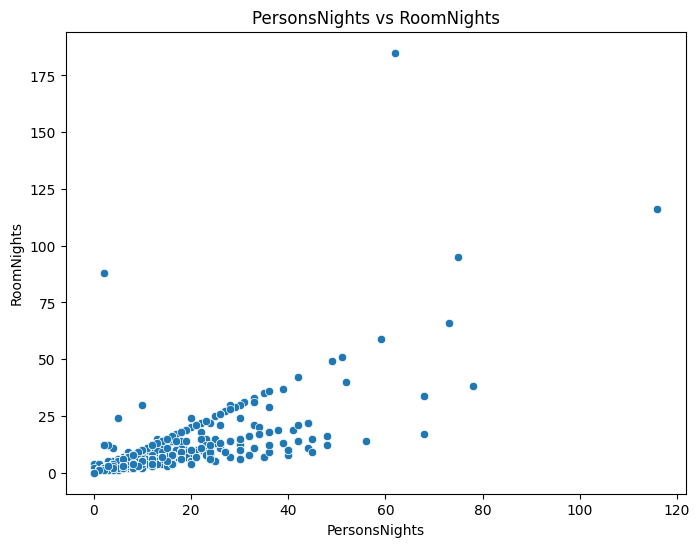

Correlation between PersonsNights and RoomNights: 0.85


In [13]:
# Calculate correlation coefficient
correlation = train_data['PersonsNights'].corr(train_data['RoomNights'])
print(f"Correlation between PersonsNights and RoomNights: {correlation:.2f}")

# Visualize the relationship using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_data['PersonsNights'], y=train_data['RoomNights'])
plt.title('PersonsNights vs RoomNights')
plt.xlabel('PersonsNights')
plt.ylabel('RoomNights')
plt.show()

# Check correlation between PersonsNights and RoomNights
correlation = train_data[['PersonsNights', 'RoomNights']].corr().iloc[0, 1]
print(f"Correlation between PersonsNights and RoomNights: {correlation:.2f}")

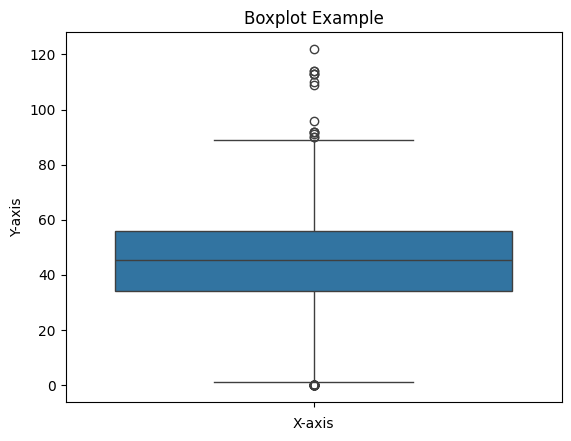

In [14]:
data = train_data["Age"]

# Creating boxplot
sns.boxplot(data)

# Adding title and labels
plt.title('Boxplot Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show plot
plt.show()

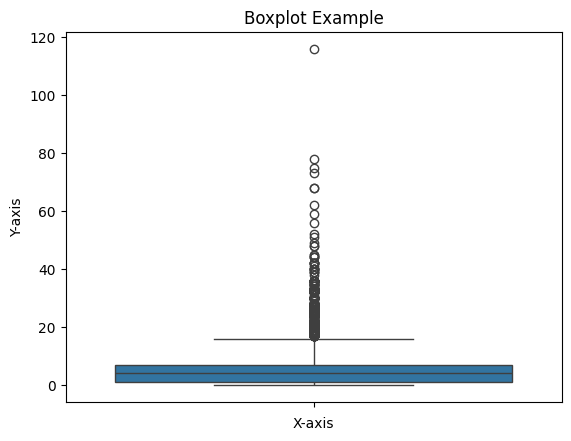

In [15]:
data = train_data["PersonsNights"]

# Creating boxplot
sns.boxplot(data)

# Adding title and labels
plt.title('Boxplot Example')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show plot
plt.show()

In [16]:
for df in [train_data, test_data]:
  if 'PersonsNights' in df.columns:
        df['PersonsNights'] = df['PersonsNights'].fillna(df['PersonsNights'].median())

In [17]:
#Drop irrelevant columns
columns_to_drop = [
    "ID", "Nationality", "Unnamed: 0", "DaysSinceCreation", "DaysSinceFirstStay",
    "MarketSegment", "RoomNights", "SRHighFloor", "SRLowFloor", "SRAccessibleRoom", "SRMediumFloor",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed", "SRNearElevator", "SRAwayFromElevator",
    "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82563 entries, 0 to 82579
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  82563 non-null  float64
 1   AverageLeadTime      82563 non-null  int64  
 2   LodgingRevenue       82563 non-null  float64
 3   OtherRevenue         82563 non-null  float64
 4   BookingsCanceled     82563 non-null  int64  
 5   BookingsNoShowed     82563 non-null  int64  
 6   BookingsCheckedIn    82563 non-null  int64  
 7   PersonsNights        82563 non-null  int64  
 8   DaysSinceLastStay    82563 non-null  int64  
 9   DistributionChannel  82563 non-null  object 
dtypes: float64(3), int64(6), object(1)
memory usage: 6.9+ MB


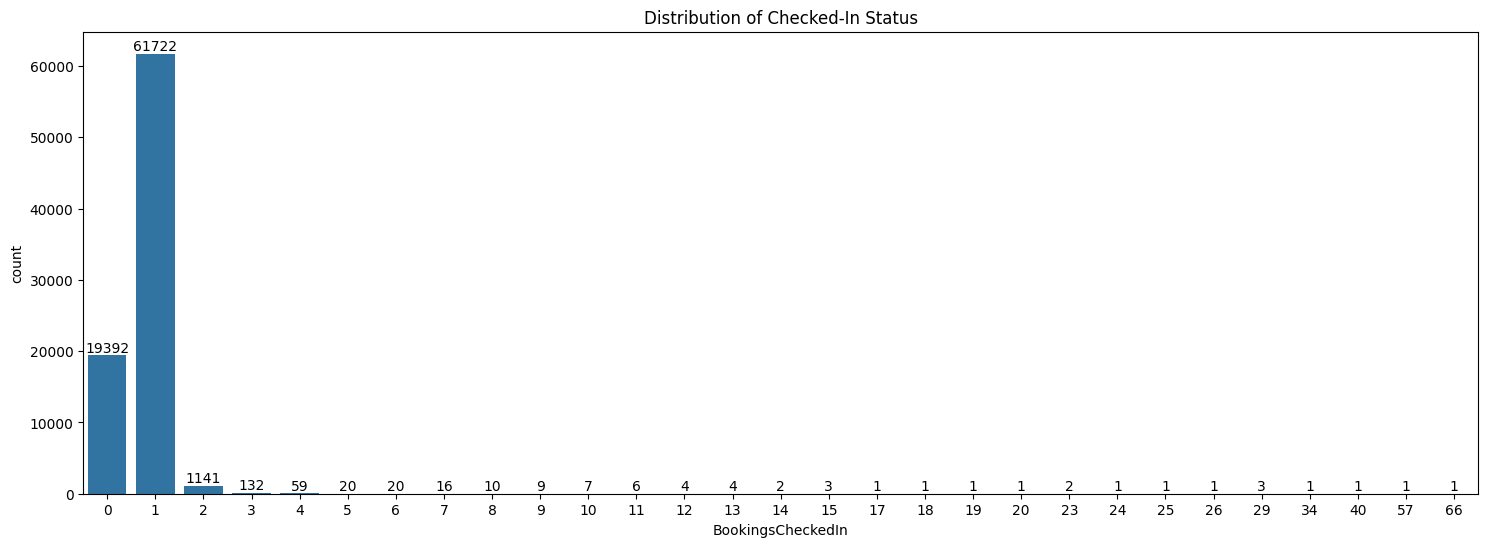

In [19]:
# Set figure size
plt.figure(figsize=(18, 6))

# Visualize distribution of the target variable
ax = sns.countplot(data=train_data, x='BookingsCheckedIn')
plt.title('Distribution of Checked-In Status')

# Add labels to each bar
for bar in ax.patches:
    count = int(bar.get_height())  # Get the height of each bar (the count)
    x_position = bar.get_x() + bar.get_width() / 2  # Center the label on the bar
    ax.text(x_position, count, f'{count}', ha='center', va='bottom')

plt.show()

Feature Distributions


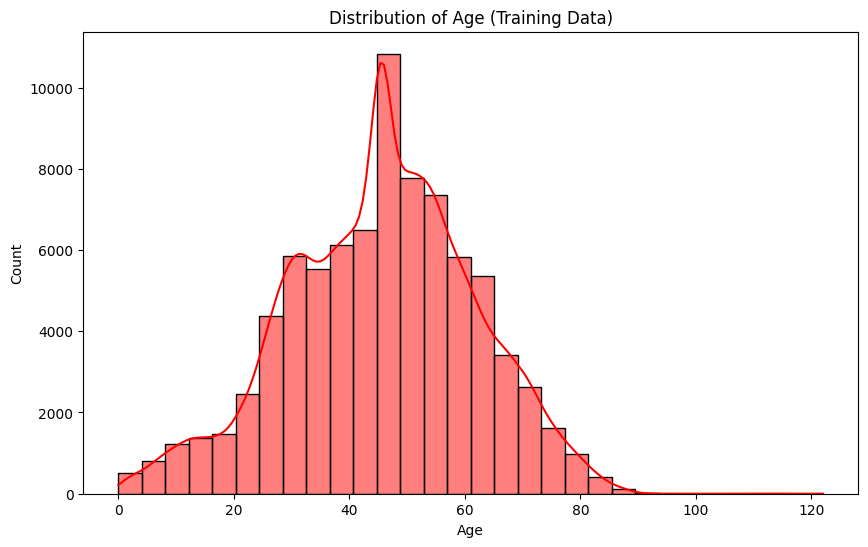

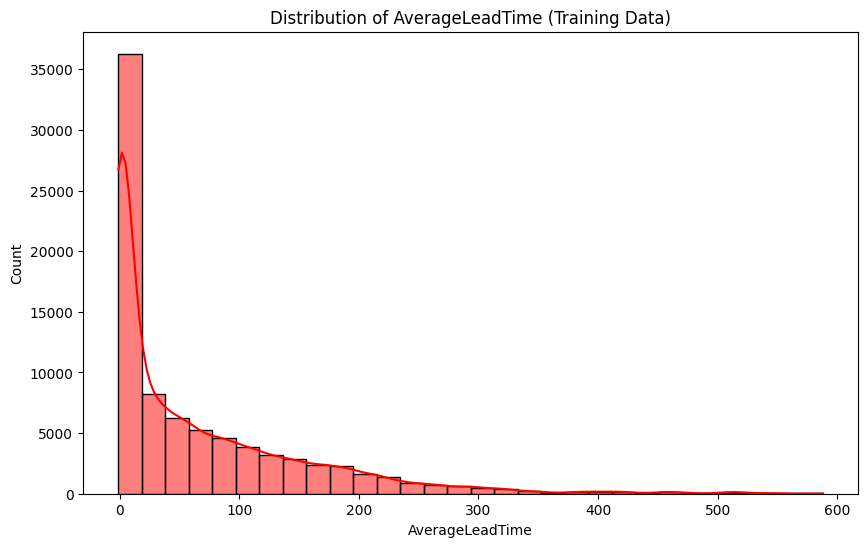

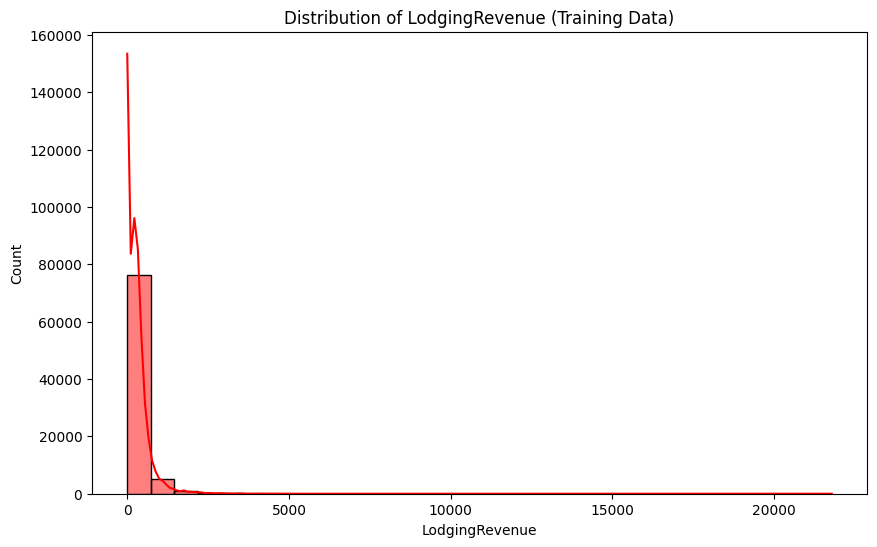

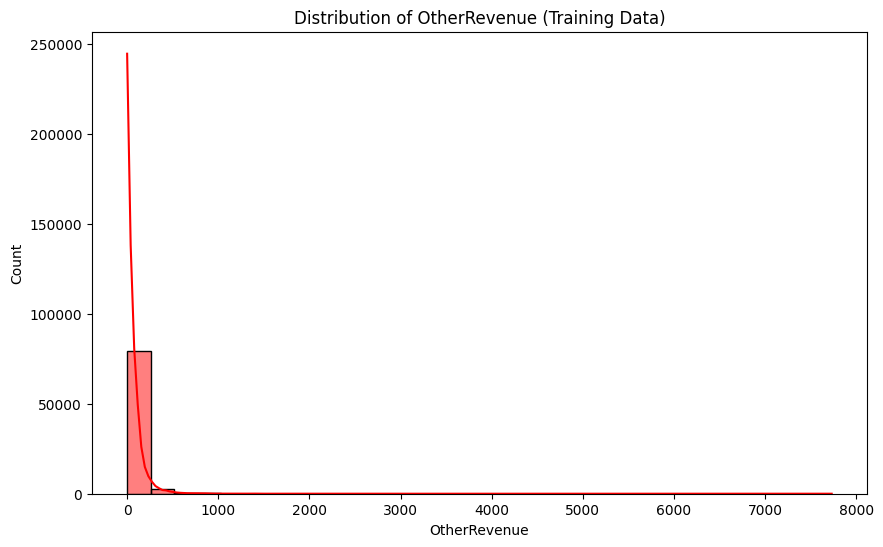

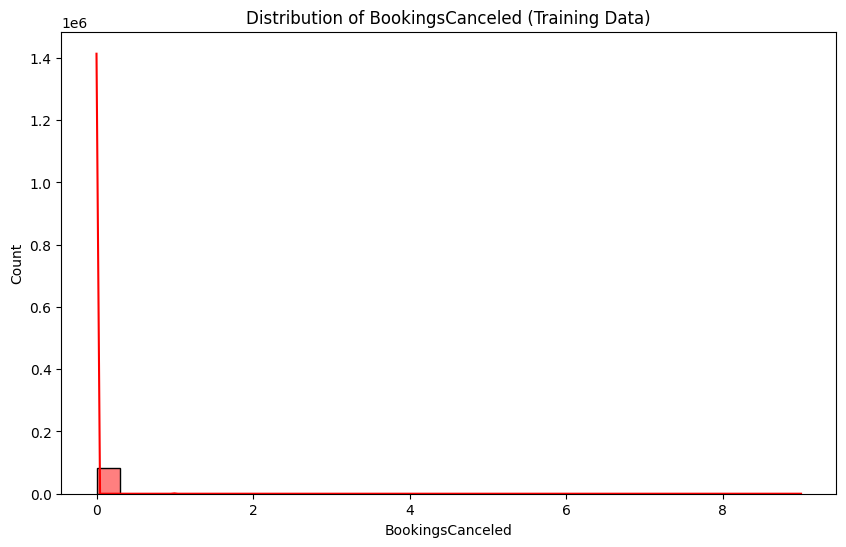

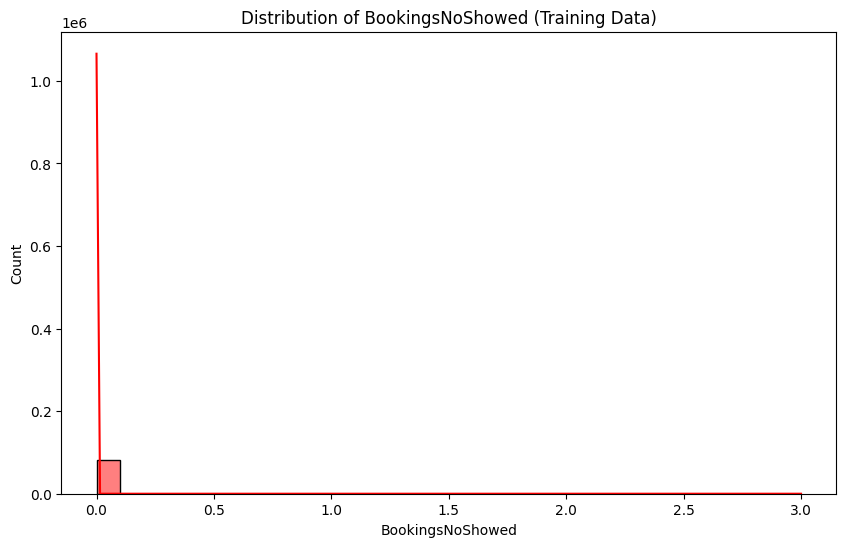

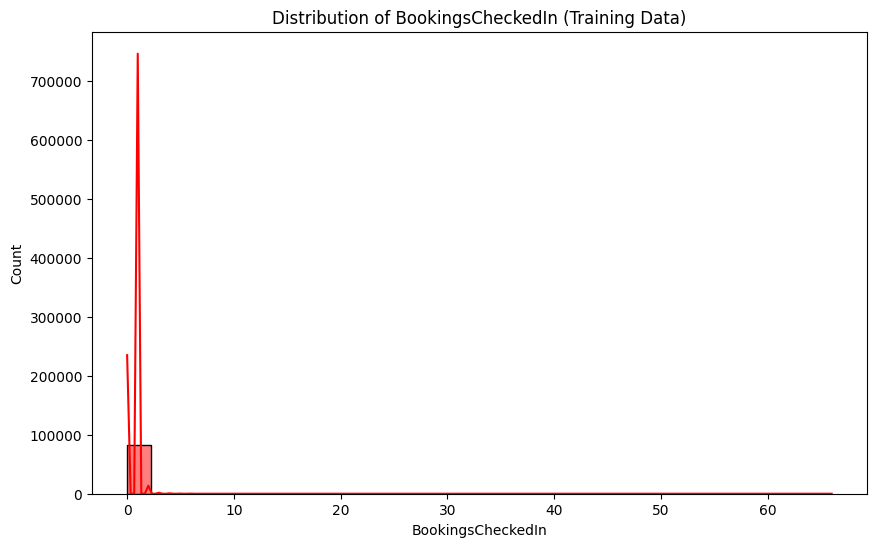

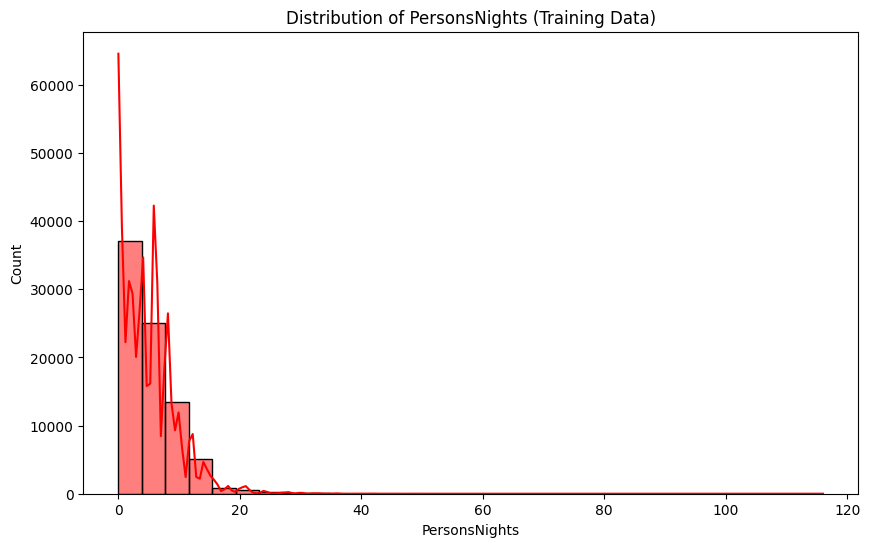

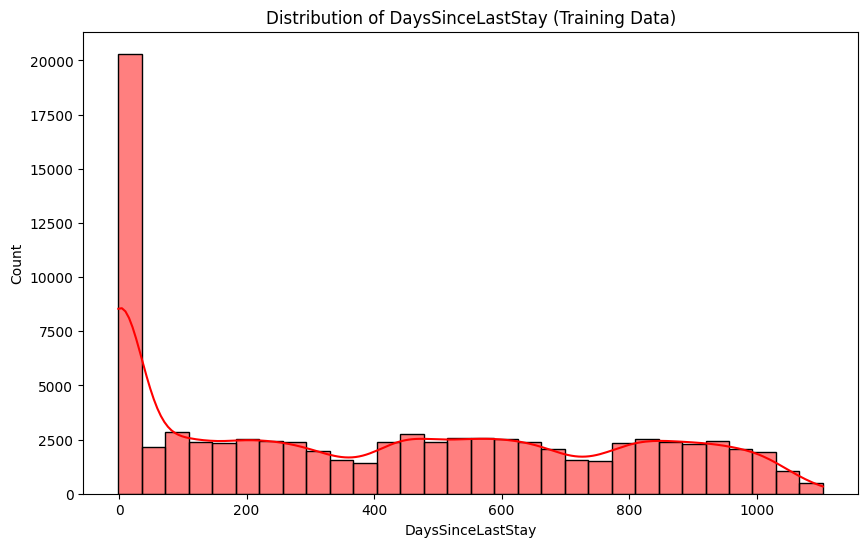

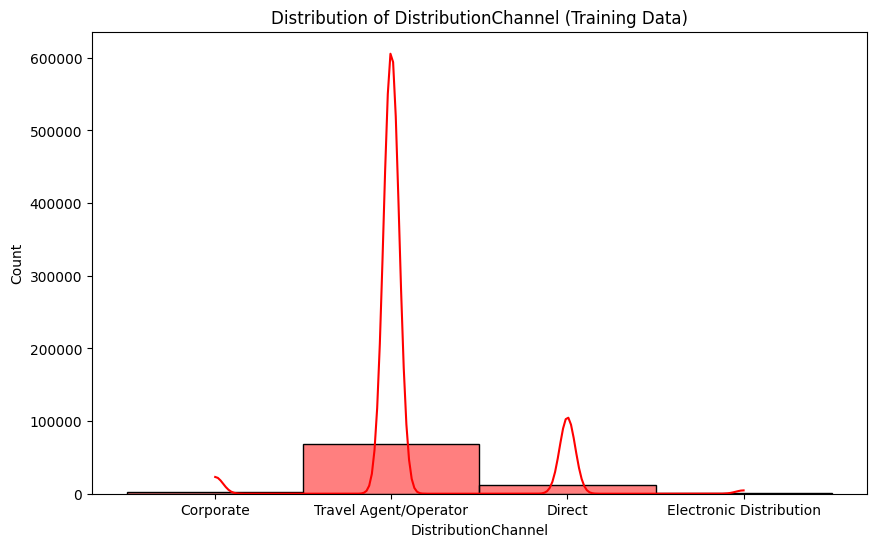

In [20]:
# Analyze and visualize the dataset
def analyze_dataset(data, title):
    print("Feature Distributions")
    for column in data.select_dtypes(include=['float64', 'int64','object']).columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data[column], kde=True, bins=30, color='Red')
        plt.title(f"Distribution of {column} ({title})")
        plt.show()

# Analyze the train and test datasets
analyze_dataset(train_data, "Training Data")

In [21]:
#Handle outliers using IQR
def cap_outliers(series, multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (multiplier * IQR)
    upper_bound = Q3 + (multiplier * IQR)
    return np.clip(series, lower_bound, upper_bound)

outlier_columns = ['Age', 'PersonsNights', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 'DaysSinceLastStay']
for col in outlier_columns:
    if col in train_data.columns:
        train_data[col] = cap_outliers(train_data[col])
    if col in test_data.columns:
        test_data[col] = cap_outliers(test_data[col])

In [22]:
# Create new features
for df in [train_data, test_data]:
    if all(col in df.columns for col in ['PersonsNights', 'LodgingRevenue', 'OtherRevenue']):
        df['RevenuePerNight'] = (
            (df['LodgingRevenue'] + df['OtherRevenue']) / df['PersonsNights']
        ).replace([np.inf, -np.inf], 0).fillna(0)

In [23]:
# Scale numerical features
scaler = MinMaxScaler()
numerical_columns = ['Age', 'PersonsNights', 'AverageLeadTime', 'LodgingRevenue', 'OtherRevenue', 'DaysSinceLastStay', 'RevenuePerNight']
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

In [24]:
# Save the scaler for later use
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [25]:
# Create derived features
for df in [train_data, test_data]:
    df['TotalBookings'] = df['BookingsCanceled'] + df['BookingsNoShowed'] + df['BookingsCheckedIn']
    df['CheckInRate'] = df['BookingsCheckedIn'] / df['TotalBookings']
    df['WillCheckIn'] = df['CheckInRate'].apply(lambda x: 1 if x >= 0.5 else 0)
    df.drop(columns=['BookingsCanceled', 'BookingsNoShowed', 'BookingsCheckedIn', 'TotalBookings', 'CheckInRate'], inplace=True)

In [26]:
train_data.head(5)

,Age,AverageLeadTime,LodgingRevenue,OtherRevenue,PersonsNights,DaysSinceLastStay,DistributionChannel,RevenuePerNight,WillCheckIn
0,0.568182,0.176245,0.407700,0.485253,0.500,0.137557,Corporate,0.058668,1
1,0.505324,0.237548,0.307698,0.244240,0.625,0.996380,Travel Agent/Operator,0.032814,1
2,0.340909,0.003831,0.000000,0.000000,0.000,0.000000,Travel Agent/Operator,0.000000,0
3,0.670455,0.360153,0.263741,0.276498,0.625,0.996380,Travel Agent/Operator,0.029562,1
4,0.568182,0.003831,0.000000,0.000000,0.000,0.000000,Travel Agent/Operator,0.000000,0


In [27]:
train_data.dtypes

,0
Age,float64
AverageLeadTime,float64
LodgingRevenue,float64
OtherRevenue,float64
PersonsNights,float64
DaysSinceLastStay,float64
DistributionChannel,object
RevenuePerNight,float64
WillCheckIn,int64


In [28]:
# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features_train = pd.DataFrame(
    encoder.fit_transform(train_data[['DistributionChannel']]),
    columns=encoder.get_feature_names_out(['DistributionChannel']),
    index=train_data.index
)
train_data = pd.concat([train_data.drop(columns=['DistributionChannel']), encoded_features_train], axis=1)

encoded_features_test = pd.DataFrame(
    encoder.transform(test_data[['DistributionChannel']]),
    columns=encoder.get_feature_names_out(['DistributionChannel']),
    index=test_data.index
)
test_data = pd.concat([test_data.drop(columns=['DistributionChannel']), encoded_features_test], axis=1)

# Save the encoder for later use
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [29]:
train_data.dtypes

,0
Age,float64
AverageLeadTime,float64
LodgingRevenue,float64
OtherRevenue,float64
PersonsNights,float64
DaysSinceLastStay,float64
RevenuePerNight,float64
WillCheckIn,int64
DistributionChannel_Corporate,float64
DistributionChannel_Direct,float64


Clean Distributions


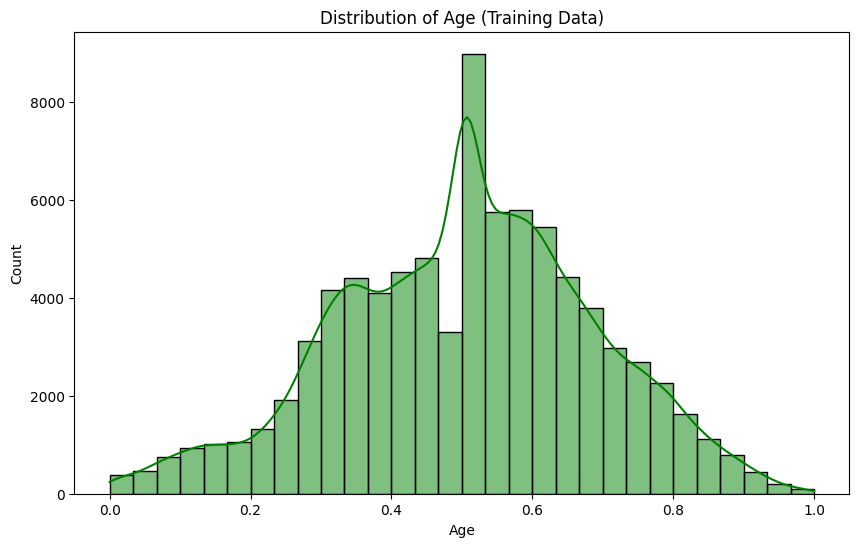

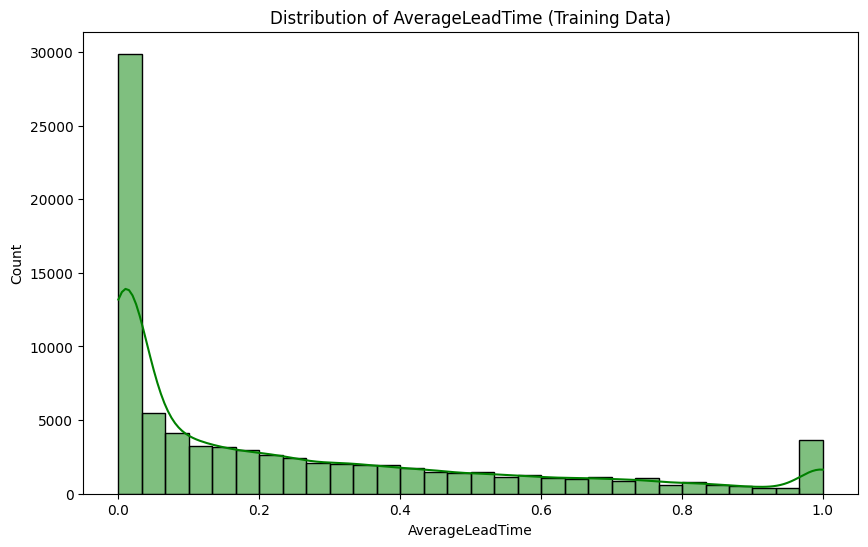

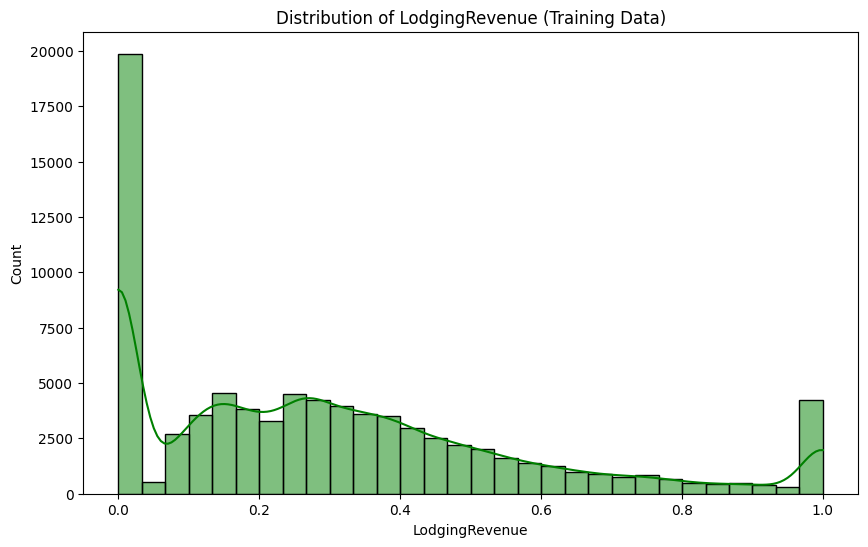

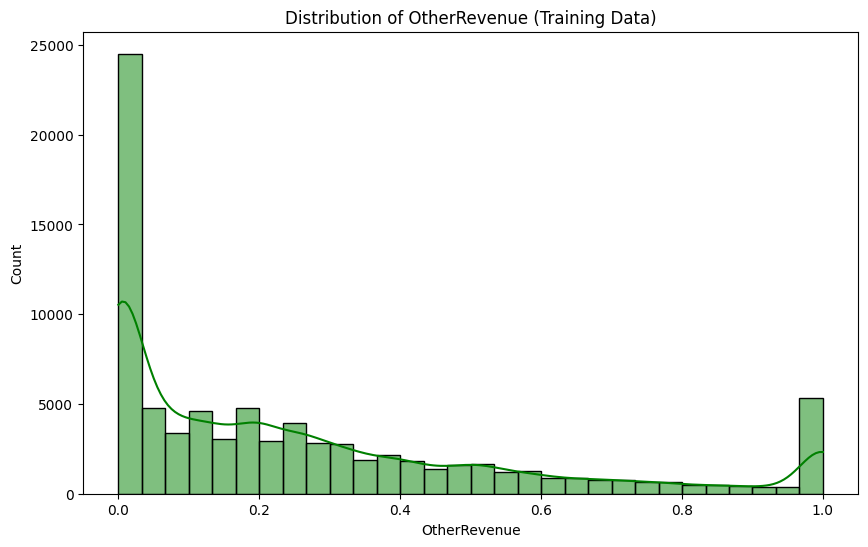

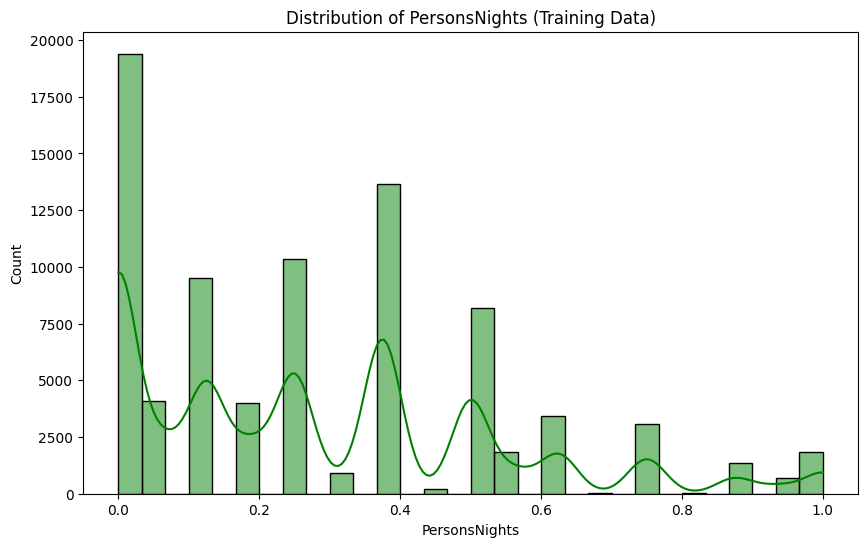

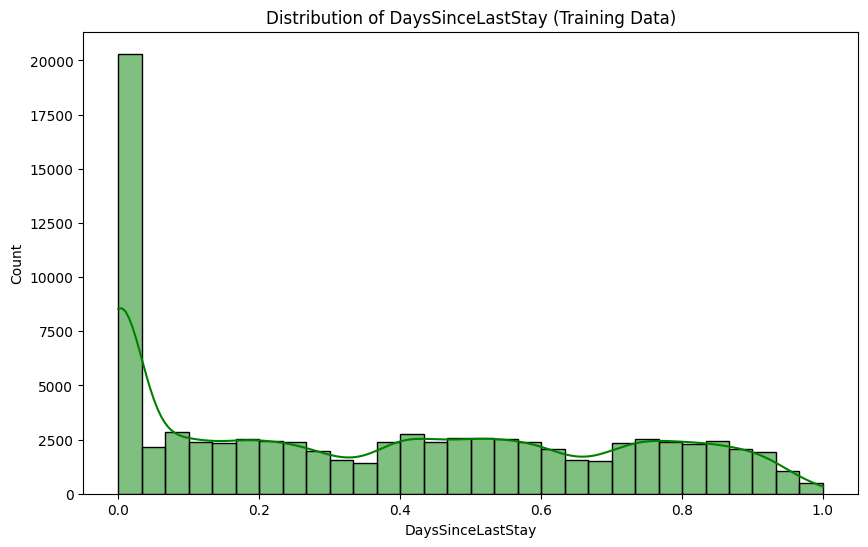

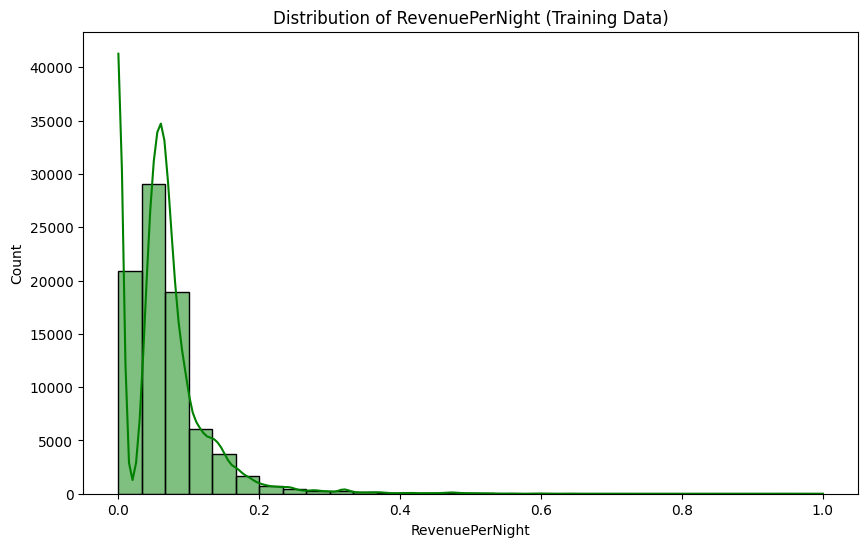

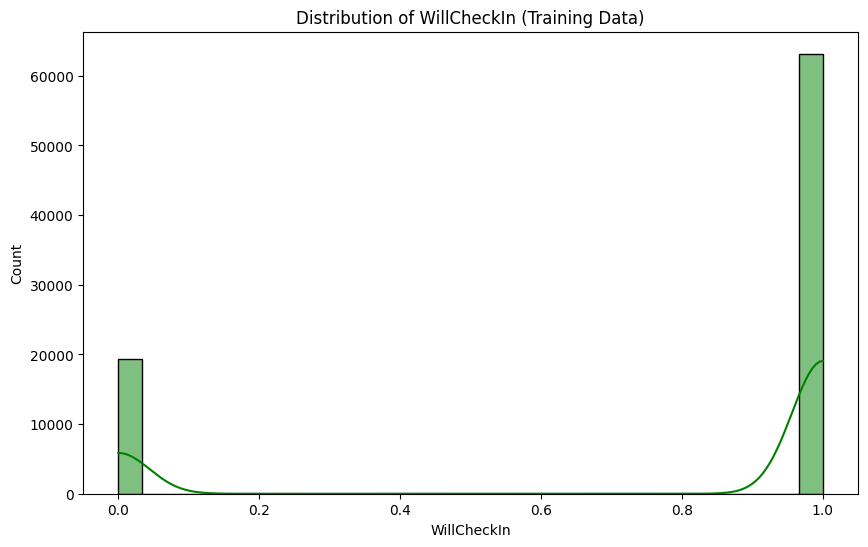

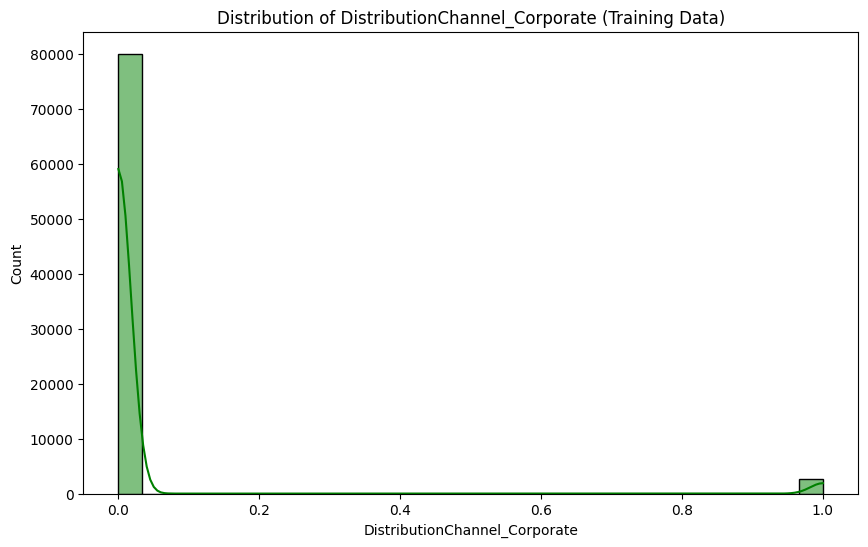

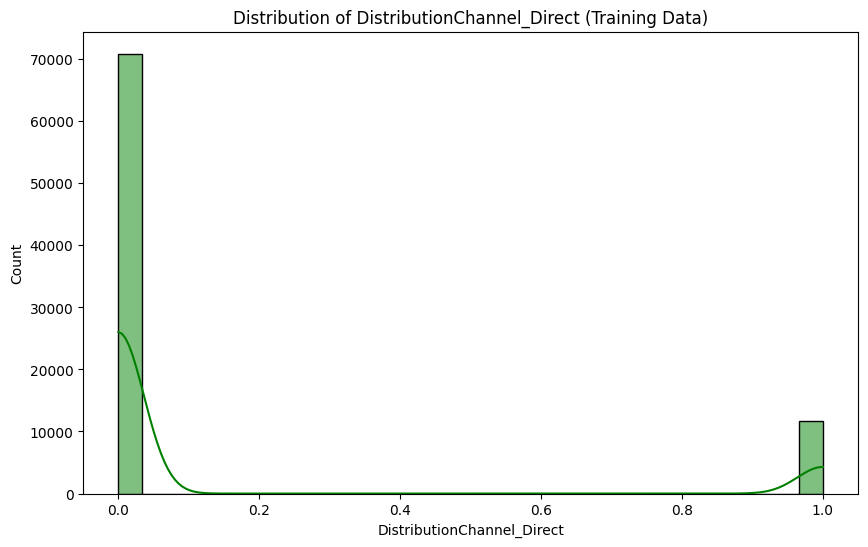

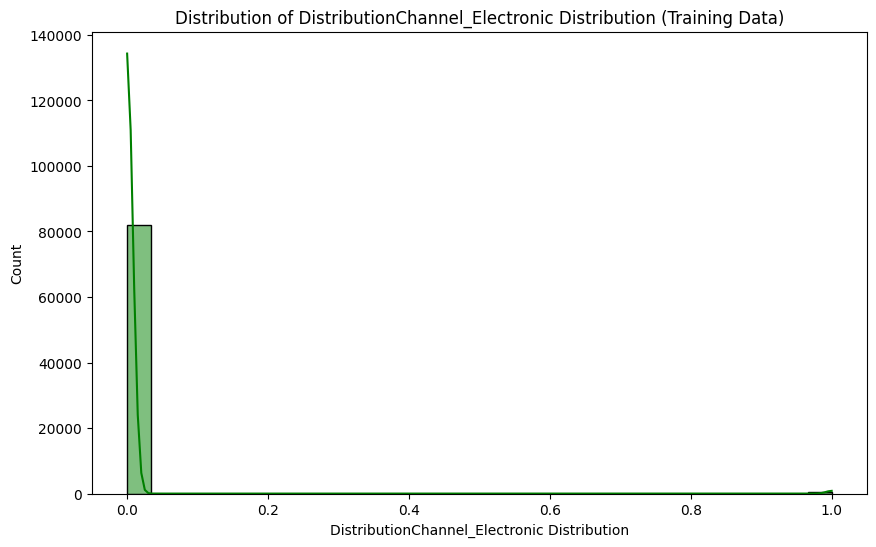

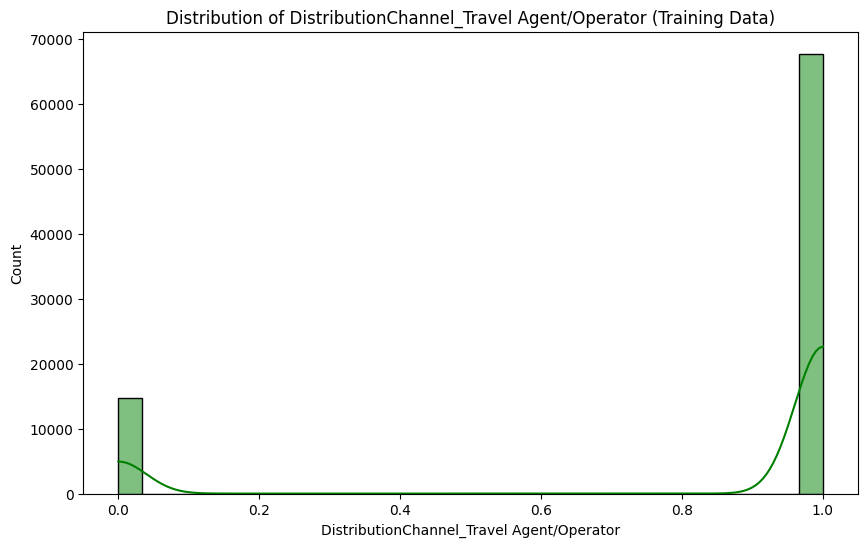

In [30]:
# Analyze and visualize the dataset
def analyze_dataset(data, title):
    print("Clean Distributions")
    for column in data.select_dtypes(include=['float64', 'int64']).columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data[column], kde=True, bins=30, color='Green')
        plt.title(f"Distribution of {column} ({title})")
        plt.show()

# Analyze the train and test datasets
analyze_dataset(train_data, "Training Data")

In [31]:
# Separate features and target
X_train = train_data.drop(columns=['WillCheckIn'])
y_train = train_data['WillCheckIn']
X_test = test_data.drop(columns=['WillCheckIn'])
y_test = test_data['WillCheckIn']

# Handle class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Standardize the data
scaler_standard = StandardScaler()
X_train = scaler_standard.fit_transform(X_train)
X_test = scaler_standard.transform(X_test)

# Save the standard scaler
joblib.dump(scaler_standard, 'standard_scaler.pkl')

['standard_scaler.pkl']


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9610 - loss: 0.5664 - val_accuracy: 0.9442 - val_loss: 0.5591 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9977 - loss: 0.0374 - val_accuracy: 0.9983 - val_loss: 0.0205 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9976 - loss: 0.0292 - val_accuracy: 0.9958 - val_loss: 0.0363 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
2065/2065 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9985 - loss: 0.0223 - val_accuracy: 0.9956 - val_loss: 0.0280 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001

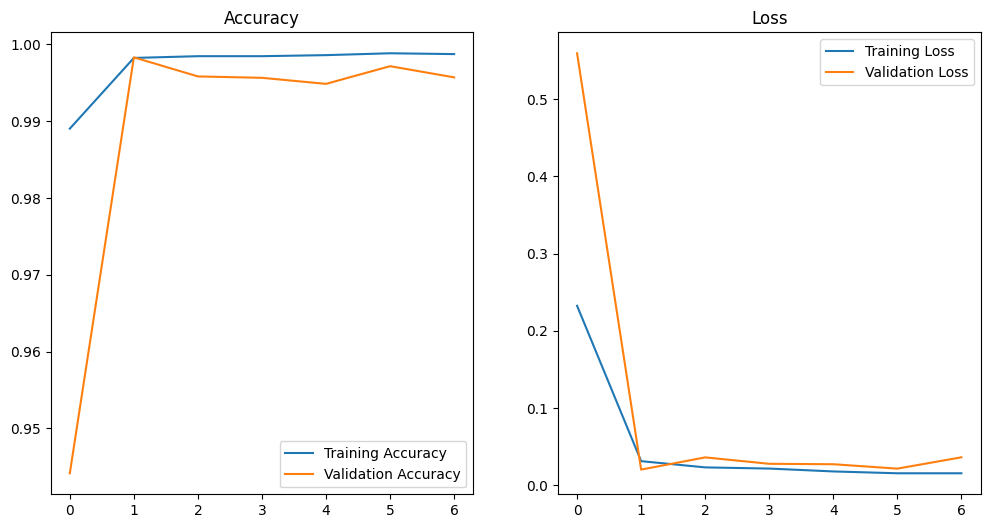

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test MAE: 0.0130
Test RMSE: 0.1140
Test Accuracy: 0.9870


In [33]:
# Convert DataFrames to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Build the neural network model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define input shape explicitly
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),  # Balanced dropout for regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model with a tuned optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Reduced patience for early stopping
    restore_best_weights=True,
    verbose=1
)

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
def scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.5
    return lr
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


# Plot training and validation metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Save the trained model
model.save('my_model.keras')

# Evaluate the model on test data
y_test_pred = (model.predict(X_test) > 0.5).astype(int)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
